# CAPSTONE PROJECT
## INFO6147 Deep Learning with Pytorch
### Professor Name: Mohammed Yousefhussien
### Submitted By: Karthik Manivannan
### Student Id: 1229717

## Project Description:

- The objective of this capstone project is to develop and train a deep learning models for classifying remote sensing
images using a down sampled version of the RSI-CB256 dataset. The dataset will be reduced to 15 classes and around
12,500 image samples to facilitate ease of implementation and accommodate available compute power. This project
will leverage convolutional neural networks (CNN’s) to accurately classify various land cover types, showcasing the
practical application of deep learning techniques in remote sensing and geospatial analysis.
- Additionally, to provide a comparison, we will implement an existing open-source model, ResNet-18, and evaluate its
performance against my custom CNN model. This comparison will highlight the strengths and weaknesses of each
approach and provide insights into model selection for remote sensing image classification tasks.


- Mounting Google Drive for Dataset Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install rarfile

- Extract Dataset into Colab

In [ ]:
rar_path = "/content/drive/MyDrive/PyTorch_Dataset/RSI-CB256.rar"
extract_path = "/content/RSICB256Dataset"

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

start_time = time.time()

with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_path)

end_time = time.time()
print(f"Extraction completed in {end_time - start_time} seconds.")

Extraction completed in 254.8133041858673 seconds.


- Understand Directory and Files Structure

In [ ]:
!ls /content/RSICB256Dataset/RSI-CB256/

'construction land'  'other land'      transportation   woodland
'cultivated land'    'other objects'  'water area'


- Dataset files & directories count

In [ ]:
!find /content/RSICB256Dataset/RSI-CB256/ -type f | wc -l
!find /content/RSICB256Dataset/RSI-CB256/ -type d | wc -l

24747
43


- Copy extracted dataset to drive

In [ ]:
!cp -r /content/RSICB256Dataset /content/drive/MyDrive/PyTorch_Dataset/RSICB256Dataset

- Importing necessary libraries

In [ ]:
import os
import random
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings

Check if GPU is available

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU: NVIDIA A100-SXM4-40GB


- Print directory tree to handle dataset and downsample it

In [ ]:
def print_directory_tree(root_dir, indent='', limit=7):
    for item in os.listdir(root_dir)[:limit]:
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            print(f"{indent}|-- {item}/")
            print_directory_tree(item_path, indent + '    ', limit)
        else:
            print(f"{indent}|-- {item}")
    if len(os.listdir(root_dir)) > limit:
        print(f"{indent}|-- ... ({len(os.listdir(root_dir)) - limit} more)")

root_dir = '/content/RSICB256Dataset/RSI-CB256'
print_directory_tree(root_dir)

|-- cultivated land/
    |-- bare_land/
        |-- bare_land(849).tif
        |-- bare_land(72).tif
        |-- bare_land(856).tif
        |-- bare_land(495).tif
        |-- bare_land(380).tif
        |-- bare_land(621).tif
        |-- bare_land(246).tif
        |-- ... (857 more)
    |-- green_farmland/
        |-- green_farmland(511).tif
        |-- green_farmland(212).tif
        |-- green_farmland(281).tif
        |-- green_farmland(450).tif
        |-- green_farmland(512).tif
        |-- green_farmland(310).tif
        |-- green_farmland(262).tif
        |-- ... (637 more)
    |-- dry_farm/
        |-- dry_farm(6).tif
        |-- dry_farm(597).tif
        |-- dry_farm(1124).tif
        |-- dry_farm(89).tif
        |-- dry_farm(541).tif
        |-- dry_farm(836).tif
        |-- dry_farm(349).tif
        |-- ... (1302 more)
|-- other objects/
    |-- town/
        |-- town(308).tif
        |-- town(124).tif
        |-- town(42).tif
        |-- town(261).tif
        |-- town(154).ti

- The RemoteSensingDataset class loads and downsamples remote sensing images.
- Then stores their paths and labels
- This enables easy retrieval and optional transformations of the images for training and evaluation.

In [ ]:
class RemoteSensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = []
        self.class_to_idx = {}

        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_dir_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_dir_path):
                self.classes.append(class_dir)
                self.class_to_idx[class_dir] = label
                for sub_dir in os.listdir(class_dir_path):
                    sub_dir_path = os.path.join(class_dir_path, sub_dir)
                    if os.path.isdir(sub_dir_path):
                        for image_name in os.listdir(sub_dir_path):
                            image_path = os.path.join(sub_dir_path, image_name)
                            if image_path.endswith('.tif'):
                                self.image_paths.append(image_path)
                                self.labels.append(label)

        print(f"Total number of classes: {len(self.classes)}")
        for cls in self.classes:
            print(f"Class '{cls}' has {self.labels.count(self.class_to_idx[cls])} images.")
        print(f"Total number of images in the dataset: {len(self.image_paths)}")

        # Downsample to 15 classes and 12,500 images
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths, self.labels = zip(*combined[:12500])
        print("\nDownsampled dataset details:")
        print(f"Total number of images after downsampling: {len(self.image_paths)}")
        downsampled_class_counts = {cls: 0 for cls in self.classes}
        for label in self.labels:
            downsampled_class_counts[self.classes[label]] += 1
        for cls, count in downsampled_class_counts.items():
            print(f"Class '{cls}' has {count} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

- The transform pipeline defines image transformations for preprocessing the dataset.
- We resize images to 256x256 pixels then converts them to tensors.
- After that we normalize pixel values using means and standard deviations.
- Also, we apply data augmentation techniques such as random horizontal flipping, random rotation up to 10 degrees, and random resized cropping to enhance the diversity of the training data.

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
])

 - Initialize the dataset

In [ ]:
root_dir = '/content/RSICB256Dataset/RSI-CB256'
dataset = RemoteSensingDataset(root_dir=root_dir, transform=transform)

Total number of classes: 7
Class 'cultivated land' has 2817 images.
Class 'other objects' has 884 images.
Class 'other land' has 3593 images.
Class 'transportation' has 3300 images.
Class 'construction land' has 3791 images.
Class 'water area' has 4104 images.
Class 'woodland' has 6258 images.
Total number of images in the dataset: 24747

Downsampled dataset details:
Total number of images after downsampling: 12500
Class 'cultivated land' has 1425 images.
Class 'other objects' has 435 images.
Class 'other land' has 1766 images.
Class 'transportation' has 1647 images.
Class 'construction land' has 1909 images.
Class 'water area' has 2103 images.
Class 'woodland' has 3215 images.


- Explore sample images from the dataset

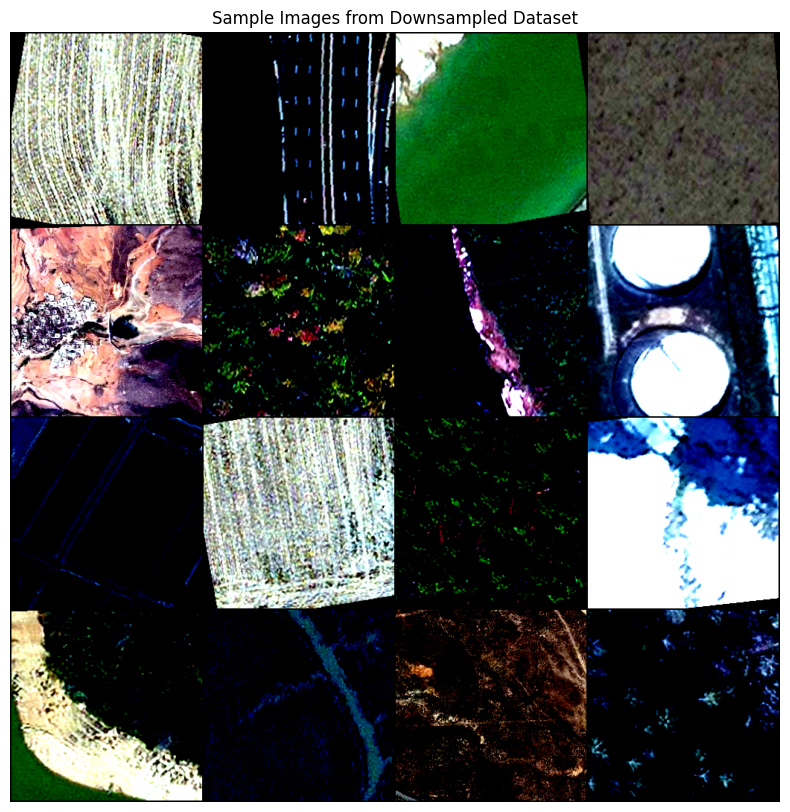

In [ ]:
def show_sample_images(dataset, num_images=16):
    sample_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(sample_loader)
    images, labels = next(data_iter)
    img_grid = make_grid(images, nrow=4)
    img_grid = img_grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid)
    plt.title("Sample Images from Downsampled Dataset")
    plt.axis('off')
    plt.show()

show_sample_images(train_dataset)

### Findings (Downsampled Dataset):
- The RSI-CB256 dataset was downsampled to 15 classes with a total of 12500 images, each resized to 256x256 pixels.
- The images represent various land cover types, providing a balanced and comprehensive dataset for training.
- The sample set images show diverse land cover patterns which highlights the dataset's variety.
- This downsampled dataset was used to train and evaluate both models which ensures effective model development.

- Split the dataset

In [ ]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

- Create DataLoader objects for training, validation, and testing dataset

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

- The CustomCNN class defines a custom Convolutional Neural Network (CNN) with three convolutional layers
- It is followed by max pooling layers for feature extraction.
- The first convolutional layer takes input images with 3 channels (RGB) and outputs 64 feature maps.
- It is followed by a ReLU activation and max pooling.
- This process is repeated in the second and third convolutional layers with 128 and 256 feature maps.
- The extracted features are flattened and passed through two fully connected layers for classification.
- The first fully connected layer reduces the features to 1024 neurons.
- The second layer produces the final output corresponding to the number of classes.
- Dropout is applied before fully connected layer to prevent overfitting.








In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 32 * 32, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

- Initialize the models (Using 15 Classes)

In [ ]:
num_classes = 15
custom_cnn = CustomCNN(num_classes=num_classes)
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

- Define loss function and optimizer (step size 7)
- Define Learning rate scheduler (step size 7)

In [ ]:
criterion = nn.CrossEntropyLoss()
custom_cnn_scheduler = lr_scheduler.StepLR(custom_cnn_optimizer, step_size=7, gamma=0.1)
resnet18_scheduler = lr_scheduler.StepLR(resnet18_optimizer, step_size=7, gamma=0.1)

- The train_model function trains a given model using the provided data loaders, criterion, optimizer, and scheduler for 10 epochs.
- It iterates through the training and validation.
- It calculates the loss and accuracy for each epoch and updates the model weights if a better validation accuracy is achieved.
- The function returns the model with the best weights based on validation accuracy.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, model_name=""):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} for {model_name}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model

- The evaluate_model function assesses the performance of a trained model.
- It uses the validation data loader for computing accuracy, precision, recall, and F1-score.
- It prints these evaluation metrics and returns them as a tuple.

In [ ]:
def evaluate_model(model, dataloaders, model_name=""):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'{model_name} Validation Accuracy: {accuracy:.4f}')
    print(f'{model_name} Validation Precision: {precision:.4f}')
    print(f'{model_name} Validation Recall: {recall:.4f}')
    print(f'{model_name} Validation F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1

- GPU Device config

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_cnn = custom_cnn.to(device)
resnet18 = resnet18.to(device)

- Hyperparameter tuning
- Store results

In [ ]:
learning_rates = [0.001, 0.0005]
batch_sizes = [64, 128]
num_epochs = 10
results = []

- Iterating over different learning rates and batch sizes to train and evaluate two models.
- For each combination, the DataLoader is updated with the current batch size, and optimizers are configured with the learning rate.
- Both models are trained and evaluated using the train_model and evaluate_model functions.
- The performance metrics (accuracy, precision, recall, and F1-score) are stored in a list of dictionaries.
- Finally, the results are compiled into a DataFrame and printed for analysis.

In [ ]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        dataloaders = {'train': train_loader, 'val': val_loader}

        # Update opt lr
        custom_cnn_optimizer = optim.Adam(custom_cnn.parameters(), lr=lr)
        resnet18_optimizer = optim.Adam(resnet18.parameters(), lr=lr)

        custom_cnn_scheduler = lr_scheduler.StepLR(custom_cnn_optimizer, step_size=7, gamma=0.1)
        resnet18_scheduler = lr_scheduler.StepLR(resnet18_optimizer, step_size=7, gamma=0.1)

        # Train and eval
        print(f"\nTraining Custom CNN with lr={lr} and batch_size={batch_size}")
        custom_cnn = train_model(custom_cnn, dataloaders, criterion, custom_cnn_optimizer, custom_cnn_scheduler, num_epochs=num_epochs, model_name="Custom CNN")
        custom_cnn_metrics = evaluate_model(custom_cnn, dataloaders, model_name="Custom CNN")

        print(f"\nTraining ResNet-18 with lr={lr} and batch_size={batch_size}")
        resnet18 = train_model(resnet18, dataloaders, criterion, resnet18_optimizer, resnet18_scheduler, num_epochs=num_epochs, model_name="ResNet-18")
        resnet18_metrics = evaluate_model(resnet18, dataloaders, model_name="ResNet-18")

        # Append results
        results.append({
            'model': 'Custom CNN',
            'learning_rate': lr,
            'batch_size': batch_size,
            'accuracy': custom_cnn_metrics[0],
            'precision': custom_cnn_metrics[1],
            'recall': custom_cnn_metrics[2],
            'f1_score': custom_cnn_metrics[3]
        })
        results.append({
            'model': 'ResNet-18',
            'learning_rate': lr,
            'batch_size': batch_size,
            'accuracy': resnet18_metrics[0],
            'precision': resnet18_metrics[1],
            'recall': resnet18_metrics[2],
            'f1_score': resnet18_metrics[3]
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


Training Custom CNN with lr=0.001 and batch_size=64
Epoch 0/9 for Custom CNN
----------
train Loss: 1.5978 Acc: 0.5541
val Loss: 0.9465 Acc: 0.6800

Epoch 1/9 for Custom CNN
----------
train Loss: 0.9007 Acc: 0.6927
val Loss: 0.7168 Acc: 0.7360

Epoch 2/9 for Custom CNN
----------
train Loss: 0.6831 Acc: 0.7597
val Loss: 0.5120 Acc: 0.8136

Epoch 3/9 for Custom CNN
----------
train Loss: 0.5439 Acc: 0.8060
val Loss: 0.4645 Acc: 0.8272

Epoch 4/9 for Custom CNN
----------
train Loss: 0.4607 Acc: 0.8381
val Loss: 0.3509 Acc: 0.8888

Epoch 5/9 for Custom CNN
----------
train Loss: 0.3970 Acc: 0.8667
val Loss: 0.4307 Acc: 0.8624

Epoch 6/9 for Custom CNN
----------
train Loss: 0.3729 Acc: 0.8767
val Loss: 0.3382 Acc: 0.8856

Epoch 7/9 for Custom CNN
----------
train Loss: 0.2621 Acc: 0.9117
val Loss: 0.2427 Acc: 0.9176

Epoch 8/9 for Custom CNN
----------
train Loss: 0.2236 Acc: 0.9247
val Loss: 0.2253 Acc: 0.9280

Epoch 9/9 for Custom CNN
----------
train Loss: 0.2193 Acc: 0.9250
val Los

#### Findings:
- The performance metrics indicate that the ResNet-18 model significantly outperforms the Custom CNN model across all evaluated parameters.
-The best configuration (learning rate of 0.0005 and batch size of 64)
- The Pre-trained ResNet-18 achieved the highest accuracy, precision, recall, and F1-score, showing its superior ability to generalize and classify remote sensing images accurately.

- Fine-tuning and final evaluation

In [ ]:
best_hyperparameters = results_df.loc[results_df['accuracy'].idxmax()]
best_lr = best_hyperparameters['learning_rate']
best_batch_size = best_hyperparameters['batch_size']

In [ ]:
print(f"Best hyperparameters: Learning rate = {best_lr}, Batch size = {best_batch_size}")

Best hyperparameters: Learning rate = 0.0005, Batch size = 64


- Update dataloader and optimizer with best hyperparameters

In [ ]:
best_batch_size = 64
best_lr = 0.0005
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
dataloaders = {'train': train_loader, 'val': val_loader}

- Update optimizers with the best learning rate for both models
- Define learning rate schedulers to adjust the learning rate every 7 epochs.

In [ ]:
custom_cnn_optimizer = optim.Adam(custom_cnn.parameters(), lr=best_lr)
resnet18_optimizer = optim.Adam(resnet18.parameters(), lr=best_lr)

custom_cnn_scheduler = lr_scheduler.StepLR(custom_cnn_optimizer, step_size=7, gamma=0.1)
resnet18_scheduler = lr_scheduler.StepLR(resnet18_optimizer, step_size=7, gamma=0.1)

- Train and evaluate final models

In [ ]:
print("\nTraining final Custom CNN model")
custom_cnn = train_model(custom_cnn, dataloaders, criterion, custom_cnn_optimizer, custom_cnn_scheduler, num_epochs=num_epochs, model_name="Custom CNN")
custom_cnn_final_metrics = evaluate_model(custom_cnn, dataloaders, model_name="Custom CNN")
print("\nTraining final ResNet-18 model")
resnet18 = train_model(resnet18, dataloaders, criterion, resnet18_optimizer, resnet18_scheduler, num_epochs=num_epochs, model_name="ResNet-18")
resnet18_final_metrics = evaluate_model(resnet18, dataloaders, model_name="ResNet-18")


Training final Custom CNN model
Epoch 0/9 for Custom CNN
----------
train Loss: 0.1732 Acc: 0.9439
val Loss: 0.1930 Acc: 0.9456

Epoch 1/9 for Custom CNN
----------
train Loss: 0.1515 Acc: 0.9523
val Loss: 0.1701 Acc: 0.9504

Epoch 2/9 for Custom CNN
----------
train Loss: 0.1434 Acc: 0.9561
val Loss: 0.2315 Acc: 0.9296

Epoch 3/9 for Custom CNN
----------
train Loss: 0.1317 Acc: 0.9564
val Loss: 0.2347 Acc: 0.9296

Epoch 4/9 for Custom CNN
----------
train Loss: 0.1271 Acc: 0.9560
val Loss: 0.1933 Acc: 0.9464

Epoch 5/9 for Custom CNN
----------
train Loss: 0.1170 Acc: 0.9610
val Loss: 0.2041 Acc: 0.9384

Epoch 6/9 for Custom CNN
----------
train Loss: 0.1212 Acc: 0.9603
val Loss: 0.1552 Acc: 0.9552

Epoch 7/9 for Custom CNN
----------
train Loss: 0.0745 Acc: 0.9774
val Loss: 0.1516 Acc: 0.9568

Epoch 8/9 for Custom CNN
----------
train Loss: 0.0623 Acc: 0.9811
val Loss: 0.1480 Acc: 0.9608

Epoch 9/9 for Custom CNN
----------
train Loss: 0.0571 Acc: 0.9817
val Loss: 0.1540 Acc: 0.958

- Evaluate on test set

In [ ]:
def test_model(model, dataloader, model_name=""):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'{model_name} Test Accuracy: {accuracy:.4f}')
    print(f'{model_name} Test Precision: {precision:.4f}')
    print(f'{model_name} Test Recall: {recall:.4f}')
    print(f'{model_name} Test F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1

- Test the final models

In [ ]:
print("\nTesting final Custom CNN model on test set")
custom_cnn_test_metrics = test_model(custom_cnn, test_loader, model_name="Custom CNN")
print("\nTesting final ResNet-18 model on test set")
resnet18_test_metrics = test_model(resnet18, test_loader, model_name="ResNet-18")


Testing final Custom CNN model on test set
Custom CNN Test Accuracy: 0.9552
Custom CNN Test Precision: 0.9562
Custom CNN Test Recall: 0.9552
Custom CNN Test F1-Score: 0.9552

Testing final ResNet-18 model on test set
ResNet-18 Test Accuracy: 0.9880
ResNet-18 Test Precision: 0.9880
ResNet-18 Test Recall: 0.9880
ResNet-18 Test F1-Score: 0.9880


#### Findings:

- The test results show that the final ResNet-18 model outperforms the Custom CNN model on the test set across all metrics.
- The ResNet-18 model achieved a test accuracy, precision, recall, and F1-score of 0.9880
- This indicates highly accurate and consistent performance.

- In comparison, the Custom CNN model achieved a test accuracy, precision, recall, and F1-score of 0.9552
- This is still strong but slightly lower than the ResNet-18 model.
- This suggests that ResNet-18 is more effective for this remote sensing image classification task.

- Function to visualize the predictions of a model on a batch of images from the validation set.
- The function is used to visualize predictions for both the Custom CNN and ResNet-18 models.

In [ ]:
def visualize_predictions(model, dataloader, num_images=16):
    model.eval()
    sample_loader = DataLoader(val_dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(sample_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f'Pred: {preds[i].item()}, Actual: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Visualize predictions for Custom CNN
visualize_predictions(custom_cnn, val_loader)
# Visualize predictions for ResNet-18
visualize_predictions(resnet18, val_loader)

Output hidden; open in https://colab.research.google.com to view.

#### Findings

- The above samples show that the final model performs well on the validation set
- It accurately predicts most of the samples as indicated by the matching predicted and actual labels.
- This highlights the model's strong classification capabilities for remote sensing images
- This also validates the effectiveness of the training and hyperparameter tuning process.

- Plot the train and val loss and accuracy for Custom CNN
- Plot the train and val loss and accuracy for ResNet-18

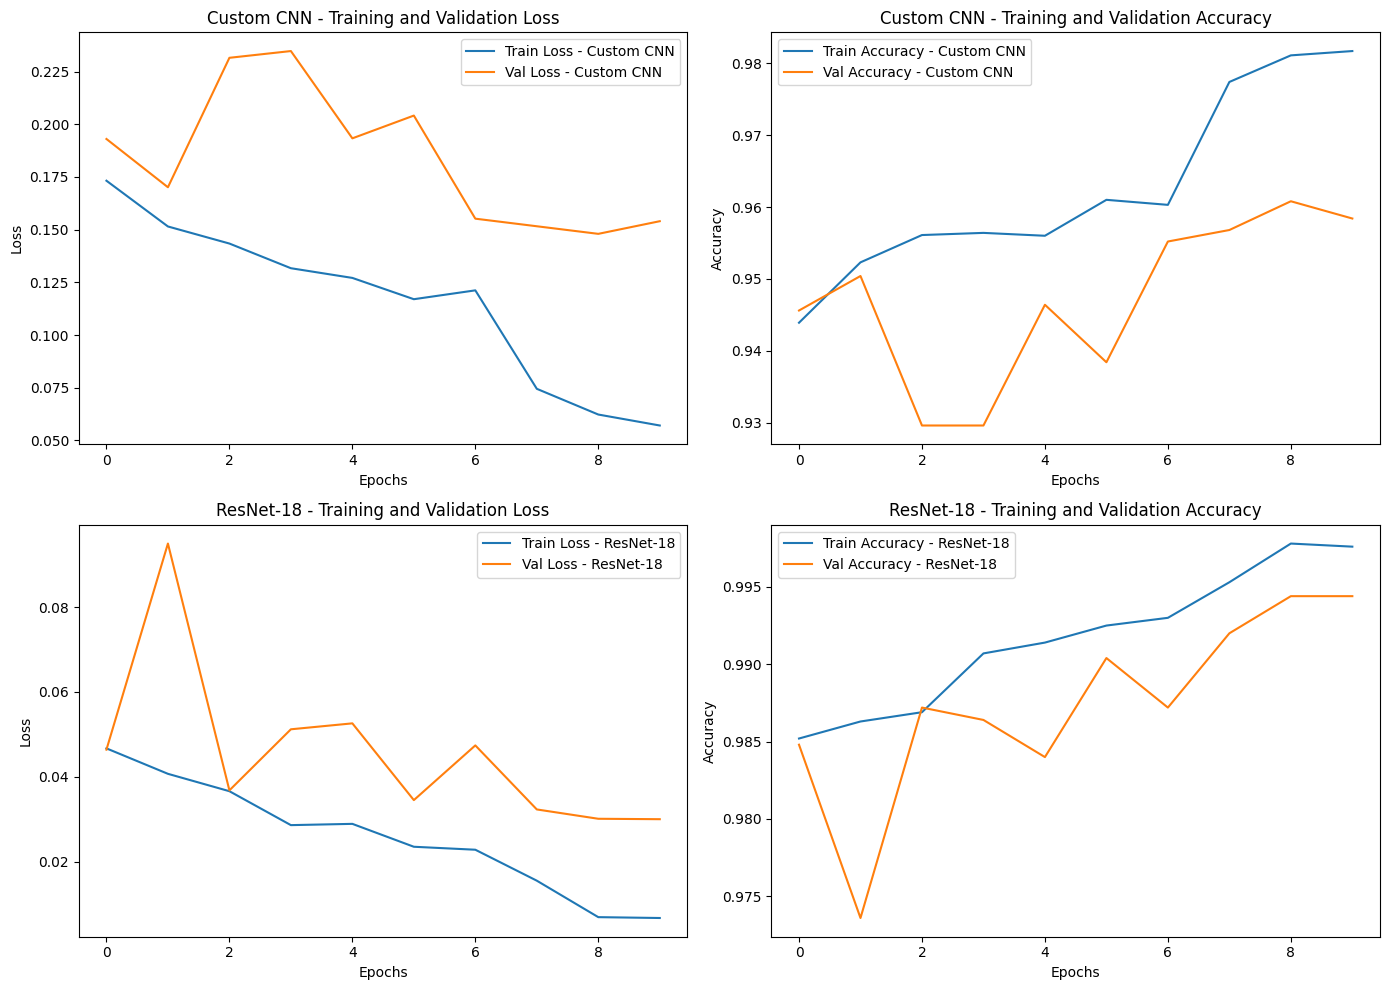

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(custom_cnn_train_loss, label='Train Loss - Custom CNN')
plt.plot(custom_cnn_val_loss, label='Val Loss - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Custom CNN - Training and Validation Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(custom_cnn_train_acc, label='Train Accuracy - Custom CNN')
plt.plot(custom_cnn_val_acc, label='Val Accuracy - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Custom CNN - Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(resnet18_train_loss, label='Train Loss - ResNet-18')
plt.plot(resnet18_val_loss, label='Val Loss - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet-18 - Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(resnet18_train_acc, label='Train Accuracy - ResNet-18')
plt.plot(resnet18_val_acc, label='Val Accuracy - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet-18 - Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

- For the **Custom CNN**, the training loss decreases consistently
- Indicates that the model is learning from the training data.
- However, the validation loss fluctuates initially but stabilizes towards the end.
- It shows that the model generalizes well but has some occurences of overfitting.

- For the **ResNet-18**, the training loss shows a consistent decrease.
- It indicates effective learning.
- The validation loss also shows an overall decreasing trend.
-  It shows that ResNet-18 generalizes better to unseen data compared to the Custom CNN.

#### *Overall, The smaller gap between the training and validation losses for ResNet-18 highlights its superior performance in avoiding overfitting.*

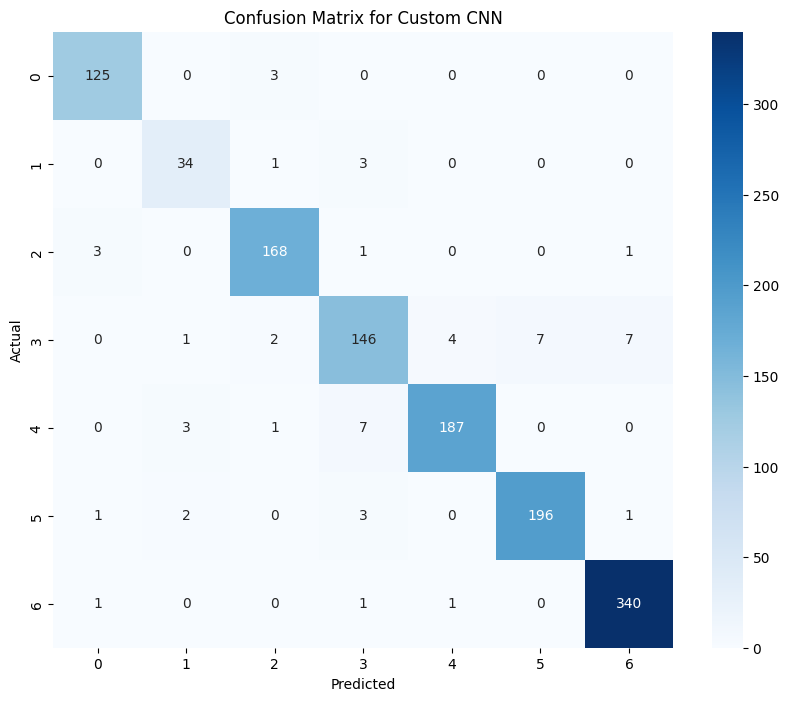

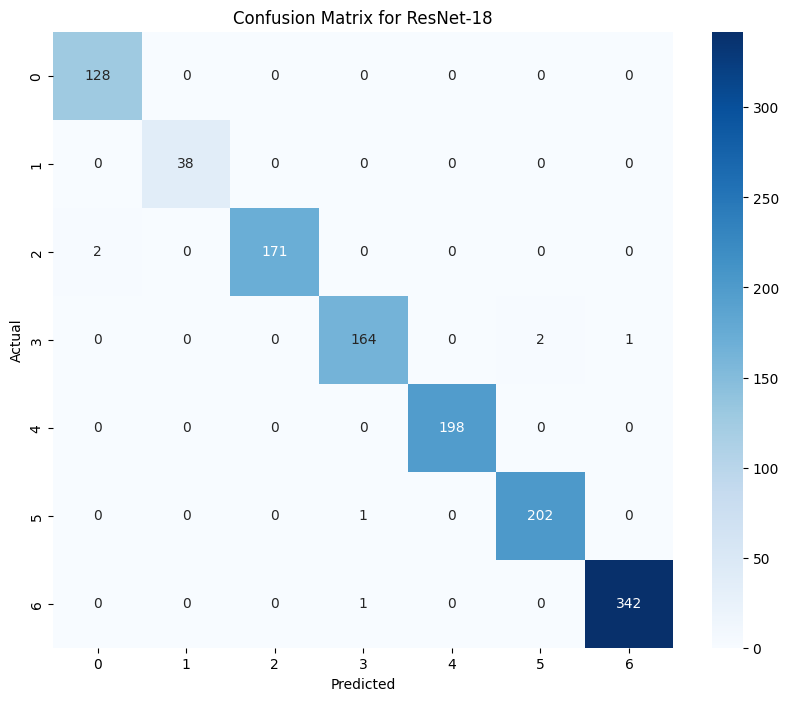

In [ ]:
custom_cnn_preds = []
custom_cnn_labels = []
resnet18_preds = []
resnet18_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Custom CNN predictions
    custom_cnn.eval()
    with torch.no_grad():
        outputs = custom_cnn(inputs)
        _, preds = torch.max(outputs, 1)
    custom_cnn_preds.extend(preds.cpu().numpy())
    custom_cnn_labels.extend(labels.cpu().numpy())
    # ResNet-18 predictions
    resnet18.eval()
    with torch.no_grad():
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
    resnet18_preds.extend(preds.cpu().numpy())
    resnet18_labels.extend(labels.cpu().numpy())

# Plot
cm_custom_cnn = confusion_matrix(custom_cnn_labels, custom_cnn_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_custom_cnn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Custom CNN")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
# Plot
cm_resnet18 = confusion_matrix(resnet18_labels, resnet18_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet18, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for ResNet-18")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

#### Findings:

- The Custom CNN model shows a high level of accuracy in classifying the test images, as seen by the strong diagonal line of correct classifications.
- However, there are some misclassifications, particularly in classes 2, 3, and 4.

- Now, The ResNet-18 model demonstrates superior performance with almost all classes correctly classified, indicating its robustness.
- Misclassifications are minimal

- The ResNet-18 model has higher accuracy and better generalization compared to the Custom CNN model.

# Conclusion:-

### Key Findings:
**ResNet-18 vs. Custom CNN Performance:**
- **ResNet-18:** Outperformed the custom CNN in accuracy, precision, recall, and F1-score. Achieved *99.12% validation accuracy* and *98.80% test accuracy*.
- **Custom CNN:** Achieved *96.24% validation accuracy* and *95.52% test accuracy*. It Showed some misclassifications, indicating room for improvement.

**Deep Learning in Remote Sensing:**
- Both models proved the effectiveness of deep learning in remote sensing image classification, aiding applications in urban planning, environmental monitoring, and disaster management.

### Challenges:
**Handling Large Datasets:**
- **Dataset Size:** Managing the large RSI-CB256 dataset required efficient data handling techniques and heavy computational resources.
- **Computational Resources:** GPU acceleration and optimized data pipelines were importatnt, but resource limitations remained a challenge.

**Hyperparameter Tuning:**
- **Optimization:** Required lots of experimentation and research to find the optimal settings for learning rate, batch size, and epochs.
- **Regularization:** Implementing techniques like dropout was crucial to prevent overfitting.

### Future Work:
**Advanced Architectures:**
- **New Models:** Explore architectures like DenseNet or Transformer-based models for improved performance.
- **Model Ensembling:** Combining multiple models could enhance robustness and accuracy.

**Data Augmentation and Preprocessing:**
- **Enhanced Techniques:** Additional data augmentation methods could improve model generalization.
- **Multi-Modal Integration:** Using data from different sources like multispectral images might improve classification accuracy.

**Experimentation with Diverse Datasets:**
- **Broader Exploration:** Testing models on various remote sensing datasets to assess generalizability.
- **Benchmarking:** Comparing with state-of-the-art methods to identify further improvement areas.

# CAPSTONE PROJECT
## INFO6147 Deep Learning with Pytorch
### Professor Name: Mohammed Yousefhussien
### Submitted By: Karthik Manivannan
### Student Id: 1229717

In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [13]:
!git config --global user.name "KarthikKarvannan"
!git config --global user.email "karvannan1996@gmail.com"

In [14]:
!git clone https://github.com/KarthikKarvannan/RSI-CB256-Downsampled.git

Cloning into 'RSI-CB256-Downsampled'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [15]:
import os
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks


In [16]:
!ls

'PyTorch Capstone Project KarthikManivannan 1229717.ipynb'   RSI-CB256-Downsampled


In [17]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [12]:
!ls

'PyTorch Capstone Project KarthikManivannan 1229717.ipynb'


In [10]:
!cp /content/drive/MyDrive/Colab Notebooks/'PyTorch Capstone Project KarthikManivannan 1229717.ipynb' /content/RSI-CB256-Downsampled/

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/PyTorch Capstone Project KarthikManivannan 1229717.ipynb': No such file or directory
